# Importing speech sentiments from Colab notebook

In [8]:
import pandas as pd
sentiments = pd.read_csv("src/Data/speech_all_finbert.csv").drop(columns=["Unnamed: 0"])
sentiments['info_channel'] = 'speech'
sentiments

,date,content,sentiment,probability,info_channel
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,positive,0.854208,speech
1,1998-07-17,Economic growth has been driven increasingly b...,positive,0.947828,speech
2,1998-07-17,"In principle, the economic performance I have ...",neutral,0.600082,speech
3,1998-07-17,"Third, further structural adjustments in fisca...",neutral,0.824068,speech
4,1998-07-17,There is currently no sign of exchange rate te...,neutral,0.756298,speech
...,...,...,...,...,...
46014,2022-02-25,Since the exchange of confidential information...,positive,0.664321,speech
46015,2022-02-25,"Last year, following discussions in the Counci...",neutral,0.762738,speech
46016,2022-02-25,This type of measure has so far only been impl...,neutral,0.897179,speech
46017,2022-02-25,The ECB incorporated in its opinions its exper...,neutral,0.868921,speech


In [9]:
import pandas as pd

def generalize_sentiments(df):
    """
    Generalizes the sentiments of a dataframe by consolidating rows with the same date.
    It aggregates content by date, computes sentiment counts, and calculates max, min, and average 
    probabilities for each sentiment type (positive, negative, neutral).

    Parameters:
    - df (pandas.DataFrame): DataFrame containing 'date', 'content', 'sentiment', 
                             and respective sentiment probabilities columns.

    Returns:
    - pandas.DataFrame: DataFrame with consolidated content and aggregated sentiment metrics.
    """
    
    # Convert content to string to avoid TypeError and concatenate for rows with the same date
    consolidated_content = df.groupby('date')['content'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Compute sentiment counts for each date
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack().reset_index().fillna(0)
    sentiment_counts.columns = ['date'] + [f"{col.lower()}_counts" for col in sentiment_counts.columns if col != 'date']

    # Compute max, min, and average probabilities for each sentiment by date
    aggregations = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        mask = df['sentiment'] == sentiment
        aggregated = df[mask].groupby('date').agg({
            'probability': ['max', 'min', 'mean']
        }).reset_index()
        
        # Flatten the multi-index column names
        aggregated.columns = ['date'] + [f"{sentiment}_{metric}" for metric in ['max', 'min', 'mean']]
        aggregations[sentiment] = aggregated

    # Merge the created dataframes to generate the final output
    result = consolidated_content
    result = pd.merge(result, sentiment_counts, on='date', how='inner')
    for sentiment in ['positive', 'negative', 'neutral']:
        result = pd.merge(result, aggregations[sentiment], on='date', how='inner')

    return result


In [11]:
gen_data = generalize_sentiments(sentiments)
gen_data['weighted_prob'] = (gen_data['negative_counts'] * gen_data['negative_mean'] * (-1) + gen_data['positive_counts'] * gen_data['positive_mean'] ) / (gen_data['negative_counts']+gen_data['positive_counts'])
gen_data['info_channel'] = 'speech'
gen_data

,date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,0.913893,0.949159,0.535464,0.845749,-0.087391,speech
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,0.723577,0.950720,0.375282,0.818889,-0.479143,speech
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,0.871450,0.946656,0.559591,0.827322,-0.436452,speech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech
1249,2022-02-10,Christine Lagarde: Hearing of the Committee on...,4.0,5.0,3.0,0.953364,0.543439,0.779126,0.943748,0.461614,0.703850,0.872223,0.506347,0.692795,-0.068289,speech
1250,2022-02-17,Christine Lagarde: Introductory statement - Eu...,3.0,8.0,5.0,0.946285,0.534803,0.763456,0.928384,0.727196,0.845817,0.895302,0.626179,0.816141,0.159978,speech


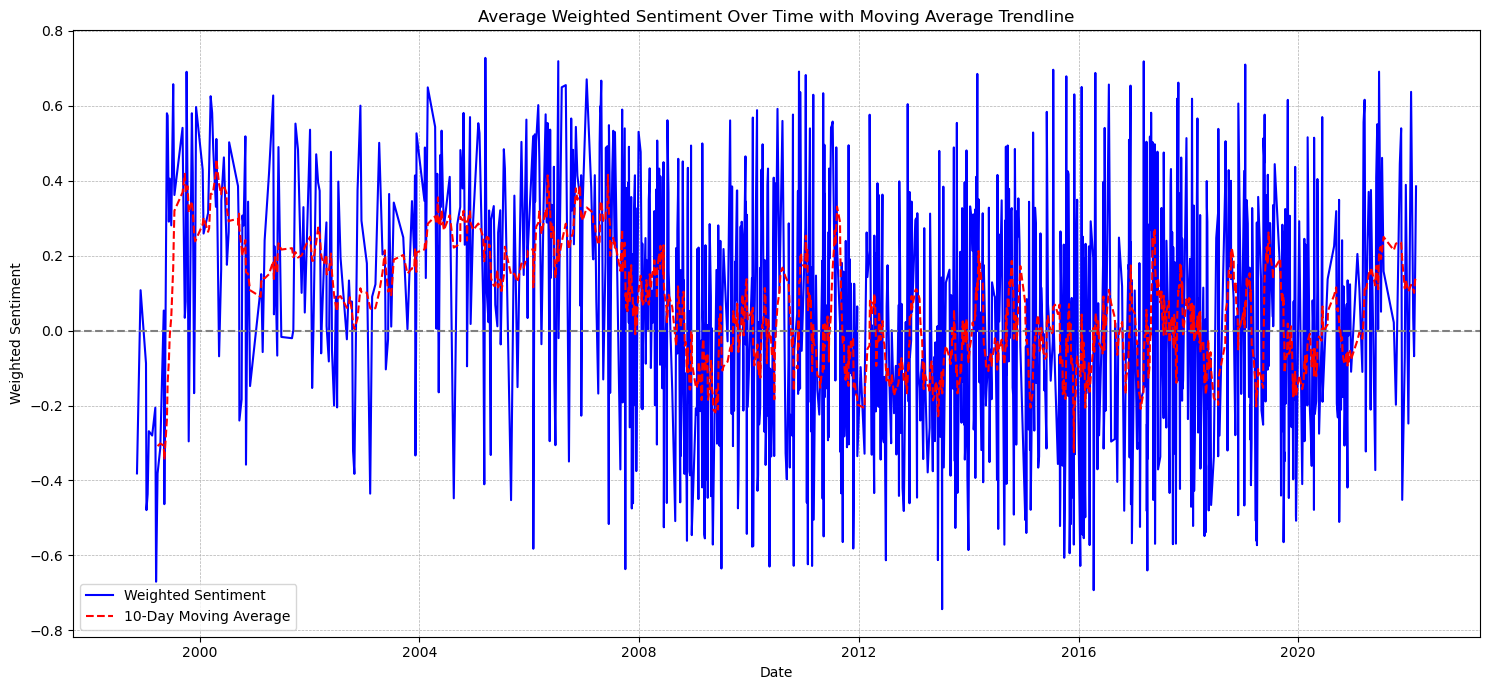

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gen_data is your dataframe
# Convert the date column to datetime type for better plotting
gen_data['date'] = pd.to_datetime(gen_data['date'])

# Calculate the moving average. Adjust the window size as needed.
window_size = 10  # Adjust this as per your preference
gen_data['moving_avg'] = gen_data['weighted_prob'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(15,7))
plt.plot(gen_data['date'], gen_data['weighted_prob'], label='Weighted Sentiment', color='blue')
plt.plot(gen_data['date'], gen_data['moving_avg'], "r--", label=f'{window_size}-Day Moving Average')
plt.axhline(y=0, color='grey', linestyle='--')  # A line at y=0 for reference

plt.title('Average Weighted Sentiment Over Time with Moving Average Trendline')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Bring other time series variables

In [7]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# calculate the daily change in the index
vstoxx_df['delta_daily'] = vstoxx_df['Indexvalue'].diff()
#vstoxx_df['delta_3d'] = vstoxx_df['Indexvalue'].diff(3)
#vstoxx_df['delta_5d'] = vstoxx_df['Indexvalue'].diff(5)
#vstoxx_df['delta_30d'] = vstoxx_df['Indexvalue'].diff(30)
#vstoxx_df['3d_pp_change'] = vstoxx_df['Indexvalue'].pct_change(3)
vstoxx_df['shifted_1_day'] = vstoxx_df['Indexvalue'].shift(-2)
vstoxx_df['delta_shifted'] = vstoxx_df['Indexvalue'] - vstoxx_df['shifted_1_day']
vstoxx_df['delta_shifted_2'] = vstoxx_df['delta_shifted'].shift(1)
# Display the DataFrame
vstoxx_df


,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,delta_daily,shifted_1_day,delta_shifted,delta_shifted_2
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,25.1670,-6.9637,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,32.5205,-2.8293,-6.9637
2,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,33.2296,-8.0626,-2.8293
3,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,36.8411,-4.3206,-8.0626
4,1999-01-08,V2TX,33.2296,08-01-1999,Friday,January,0.7091,37.5664,-4.3368,-4.3206
...,...,...,...,...,...,...,...,...,...,...
6268,2023-08-15,V2TX,18.8579,15-08-2023,Tuesday,August,0.8050,20.3539,-1.4960,-0.4981
6269,2023-08-16,V2TX,18.5510,16-08-2023,Wednesday,August,-0.3069,20.2456,-1.6946,-1.4960
6270,2023-08-17,V2TX,20.3539,17-08-2023,Thursday,August,1.8029,19.8367,0.5172,-1.6946
6271,2023-08-18,V2TX,20.2456,18-08-2023,Friday,August,-0.1083,NaN,NaN,0.5172


# Bond price data

In [113]:
bond_data = pd.read_csv("src/Data/10_year_maturity.csv")
# change variable names to Date and 10_y_bond_yield
bond_data.columns = ['Date', 'Date_2', '10_y_bond_yield']
# drop the second date column
bond_data = bond_data.drop(columns=['Date_2'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data

,Date,10_y_bond_yield
0,2004-09-06,4.209220
1,2004-09-07,4.209626
2,2004-09-08,4.228419
3,2004-09-09,4.161872
4,2004-09-10,4.120981
...,...,...
4867,2023-09-15,2.734948
4868,2023-09-18,2.788173
4869,2023-09-19,2.807675
4870,2023-09-20,2.765770


In [29]:
# import the yield curve data
yield_curve = pd.read_csv("src/Data/euro_yield_curve.csv")

# Select only 'date' and 's1' columns
yield_curve = yield_curve[['date', 's1']]

# Rename the 's1' column to 's1_yield'
yield_curve.rename(columns={'s1': 's1_yield'}, inplace=True)

yield_curve 

,date,s1_yield
0,2004-09-06,3.298175
1,2004-09-07,3.338711
2,2004-09-08,3.375993
3,2004-09-09,3.284360
4,2004-09-10,3.208441
...,...,...
4843,2023-08-14,2.370727
4844,2023-08-15,2.448853
4845,2023-08-16,2.428063
4846,2023-08-17,2.466451


In [120]:
# main refinance rate Eurozone
ref_rate = pd.read_csv("src/Data/main_ref_rate.csv")
# keep only date, s3, s8 and s10
ref_rate = ref_rate[['date', 's3', 's8', 's10']]
# input the last value to the NaNs
ref_rate['s3'] = ref_rate['s3'].fillna(method='ffill')
#remove the NaNs
ref_rate = ref_rate.dropna()
# transform 1998-12-31 24:00:00 to 1999-01-01 format in date column
ref_rate['date'] = ref_rate['date'].str.replace('24:00:00', '00:00:00')
# convert date to datetime format
ref_rate['date'] = pd.to_datetime(ref_rate['date'])

ref_rate

,date,s3,s8,s10
3,1999-01-03,-1.25,0.75,-1.25
4,1999-01-04,-1.25,0.75,-1.25
5,1999-01-05,-1.25,0.75,-1.25
6,1999-01-06,-1.25,0.75,-1.25
7,1999-01-07,-1.25,0.75,-1.25
...,...,...,...,...
9005,2023-08-27,0.25,0.25,0.25
9006,2023-08-28,0.25,0.25,0.25
9007,2023-08-29,0.25,0.25,0.25
9008,2023-08-30,0.25,0.25,0.25


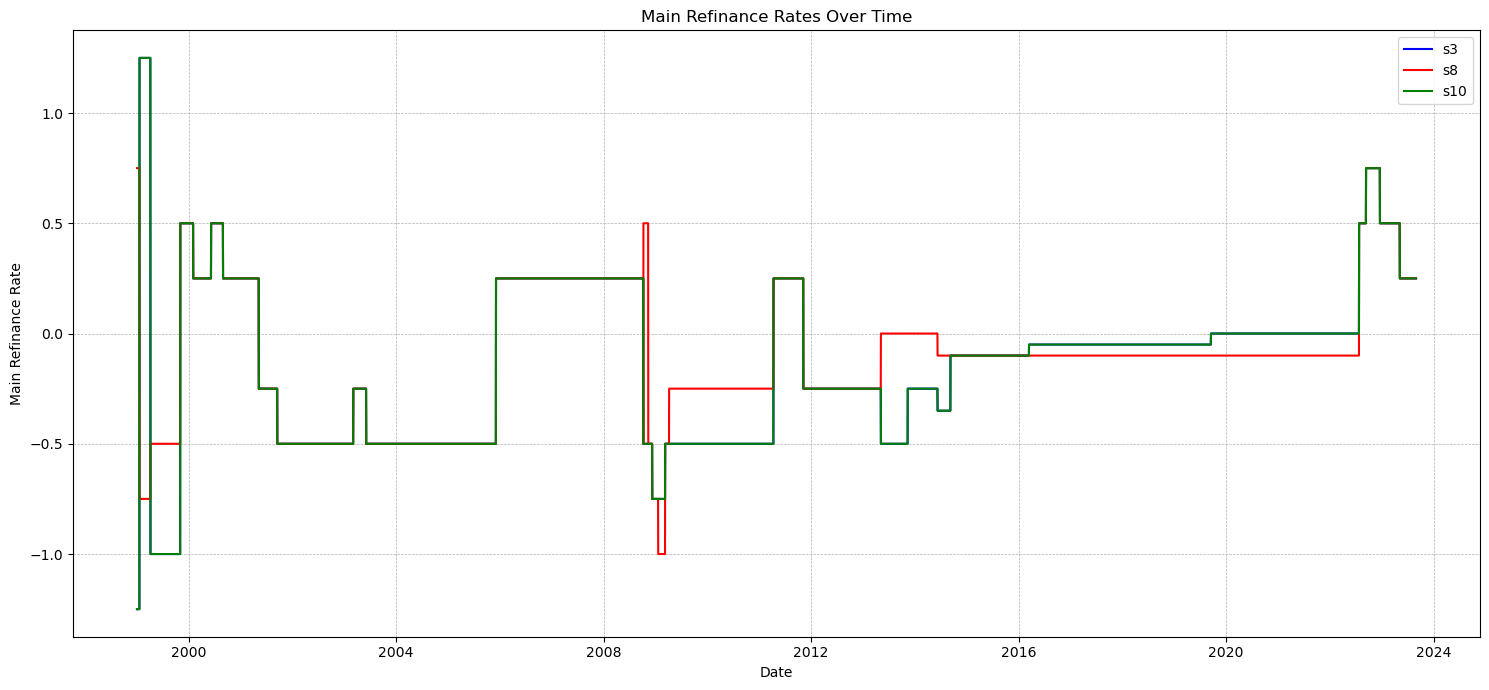

In [121]:
# plot s3, s8 and s10 rates over time
plt.figure(figsize=(15,7))
plt.plot(ref_rate['date'], ref_rate['s3'], label='s3', color='blue')
plt.plot(ref_rate['date'], ref_rate['s8'], label='s8', color='red')
plt.plot(ref_rate['date'], ref_rate['s10'], label='s10', color='green')
plt.title('Main Refinance Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Main Refinance Rate')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Labor and unemployment data

In [124]:
# import and transform the data for labor productivity
labor = pd.read_csv("src/Data/Labor_productivity.csv")

# import and transform the data for unemployment
unemployment = pd.read_csv("src/Data/Unemployment.csv")


In [125]:
unemployment

,date,conf,status1,s1
0,2000-01-30 24:00:00,NaN,Normal value,9.44
1,2000-02-28 24:00:00,NaN,Normal value,9.35
2,2000-03-30 24:00:00,NaN,Normal value,9.26
3,2000-04-29 24:00:00,NaN,Normal value,9.18
4,2000-05-30 24:00:00,NaN,Normal value,9.12
...,...,...,...,...
277,2023-02-27 24:00:00,NaN,Normal value,6.59
278,2023-03-30 24:00:00,NaN,Normal value,6.52
279,2023-04-29 24:00:00,NaN,Normal value,6.45
280,2023-05-30 24:00:00,NaN,Normal value,6.40


In [126]:
# Adjust the time and increment the date
def adjust_time(date_string):
    if '24:00:00' in date_string:
        date_string = date_string.replace('24:00:00', '00:00:00')
        date_object = pd.to_datetime(date_string) + pd.Timedelta(days=1)
        return date_object.date()
    else:
        return pd.to_datetime(date_string).date()

labor['date'] = labor['date'].apply(adjust_time)
unemployment['date'] = unemployment['date'].apply(adjust_time)

In [127]:
# Merge the dataframes using an outer join and suffixes for columns from each dataframe
labor_unemployment = pd.merge(labor[['date', 's1']], unemployment[['date', 's1']], on='date', how='outer', suffixes=('_labor', '_unemployment'))

# Rename the columns for clarity
labor_unemployment.rename(columns={'s1_labor': 'labor_prod_s1', 's1_unemployment': 'unemployment_s1'}, inplace=True)
labor_unemployment

,date,labor_prod_s1,unemployment_s1
0,1999-03-31,0.22,NaN
1,1999-06-30,0.38,NaN
2,1999-09-30,1.01,NaN
3,1999-12-31,2.01,NaN
4,2000-03-31,1.96,9.26
...,...,...,...
281,2022-11-30,NaN,6.68
282,2023-01-31,NaN,6.67
283,2023-02-28,NaN,6.59
284,2023-04-30,NaN,6.45


# Dax data

In [136]:
import yfinance as yf
import pandas as pd

# Define the ticker symbols and the date range
ticker_dax = "DAX"
ticker_vdax = "^VDAX"
start_date = "1999-01-01"
end_date = "2022-12-31"

# Fetch data for DAX
dax_data = yf.download(ticker_dax, start=start_date, end=end_date)

# Fetch data for VDAX
vdax_data = yf.download(ticker_vdax, start=start_date, end=end_date)

# Create a single DataFrame by merging on Date
dax_selected = pd.merge(dax_data[['Close', 'Volume']], vdax_data[['Close', 'Volume']], left_index=True, right_index=True, how='outer', suffixes=('_dax', '_vdax'))

# Rename columns
dax_selected.columns = ['Close_dax', 'Volume_dax', 'Close_vdax', 'Volume_vdax']

# Reset index to have Date as a column
dax_selected = dax_selected.reset_index().rename(columns={"index": "Date"})

dax_selected

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Close_dax,Volume_dax,Close_vdax,Volume_vdax
0,2005-11-16,NaN,NaN,14.65,0.0
1,2005-11-17,NaN,NaN,14.54,0.0
2,2005-11-18,NaN,NaN,14.35,0.0
3,2005-11-21,NaN,NaN,13.56,0.0
4,2005-11-22,NaN,NaN,13.69,0.0
...,...,...,...,...,...
4269,2022-12-23,25.60,1400.0,NaN,NaN
4270,2022-12-27,25.77,8800.0,NaN,NaN
4271,2022-12-28,25.49,18200.0,NaN,NaN
4272,2022-12-29,26.15,13500.0,NaN,NaN


# Merge all of them into one


In [148]:
# Convert all 'Date' columns to datetime format
dax_selected['Date'] = pd.to_datetime(dax_selected['Date'])
labor_unemployment['Date'] = pd.to_datetime(labor_unemployment['date'])
yield_curve['Date'] = pd.to_datetime(yield_curve['Date'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
vstoxx_df['Date'] = pd.to_datetime(vstoxx_df['Date'])
gen_data['Date'] = pd.to_datetime(gen_data['Date'])
ref_rate['Date'] = pd.to_datetime(ref_rate['date'])

# Now, proceed with the merge
merged_df = dax_selected.merge(labor_unemployment, on='Date', how='outer')
merged_df = merged_df.merge(yield_curve, on='Date', how='outer')
merged_df = merged_df.merge(bond_data, on='Date', how='outer')
merged_df = merged_df.merge(vstoxx_df, on='Date', how='outer')
merged_df = merged_df.merge(gen_data, on='Date', how='outer')
merged_df = merged_df.merge(ref_rate, on='Date', how='outer')
# Examine the resulting dataframe
print(merged_df.head())
print(merged_df.shape)


        Date  Close_dax  Volume_dax  Close_vdax  Volume_vdax date_x  \
0 2005-11-16        NaN         NaN       14.65          0.0    NaN   
1 2005-11-17        NaN         NaN       14.54          0.0    NaN   
2 2005-11-18        NaN         NaN       14.35          0.0    NaN   
3 2005-11-21        NaN         NaN       13.56          0.0    NaN   
4 2005-11-22        NaN         NaN       13.69          0.0    NaN   

   labor_prod_s1  unemployment_s1  s1_yield  10_y_bond_yield  ... neutral_max  \
0            NaN              NaN  2.904758         3.456645  ...         NaN   
1            NaN              NaN  2.949934         3.475680  ...         NaN   
2            NaN              NaN  3.069669         3.532530  ...         NaN   
3            NaN              NaN  3.063077         3.534695  ...         NaN   
4            NaN              NaN  3.024579         3.509495  ...         NaN   

   neutral_min neutral_mean weighted_prob info_channel  moving_avg     date_y  \
0    

In [149]:
merged_df.columns.tolist()


['Date',
 'Close_dax',
 'Volume_dax',
 'Close_vdax',
 'Volume_vdax',
 'date_x',
 'labor_prod_s1',
 'unemployment_s1',
 's1_yield',
 '10_y_bond_yield',
 'Symbol',
 'Indexvalue',
 'Date_merge',
 'day_of_week',
 'month',
 'delta_daily',
 'shifted_1_day',
 'delta_shifted',
 'delta_shifted_2',
 'content',
 'negative_counts',
 'neutral_counts',
 'positive_counts',
 'positive_max',
 'positive_min',
 'positive_mean',
 'negative_max',
 'negative_min',
 'negative_mean',
 'neutral_max',
 'neutral_min',
 'neutral_mean',
 'weighted_prob',
 'info_channel',
 'moving_avg',
 'date_y',
 's3',
 's8',
 's10']

In [150]:
# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

print(nan_table)


                 NaN/Null Count
Date                          0
Close_dax                  6962
Volume_dax                 6962
Close_vdax                 6374
Volume_vdax                6374
date_x                     8738
labor_prod_s1              8926
unemployment_s1            8742
s1_yield                   4176
10_y_bond_yield            4152
Symbol                     2751
Indexvalue                 2751
Date_merge                 2751
day_of_week                2751
month                      2751
delta_daily                2752
shifted_1_day              2753
delta_shifted              2753
delta_shifted_2            2753
content                    7772
negative_counts            7772
neutral_counts             7772
positive_counts            7772
positive_max               7772
positive_min               7772
positive_mean              7772
negative_max               7772
negative_min               7772
negative_mean              7772
neutral_max                7772
neutral_

In [151]:
"""
columns_to_fill = [
    'Close_dax',
    'Volume_dax',
    'Close_vdax',
    'Volume_vdax',
    'labor_prod_s1',
    'unemployment_s1',
    's1_yield',
    'bond_price',
    'b_delta_daily',
    'Indexvalue'
]

for column in columns_to_fill:
    merged_df[column] = merged_df[column].fillna(method='ffill')

merged_df
"""

"\ncolumns_to_fill = [\n    'Close_dax',\n    'Volume_dax',\n    'Close_vdax',\n    'Volume_vdax',\n    'labor_prod_s1',\n    'unemployment_s1',\n    's1_yield',\n    'bond_price',\n    'b_delta_daily',\n    'Indexvalue'\n]\n\nfor column in columns_to_fill:\n    merged_df[column] = merged_df[column].fillna(method='ffill')\n\nmerged_df\n"

In [152]:
# Filter the rows based on the 'Date' column
merged_df = merged_df[merged_df['Date'] > '2005-01-01']

# filter and keep only where weighted_prob	exists
merged_df = merged_df[merged_df['weighted_prob'].notna()]

# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

nan_table


,NaN/Null Count
Date,0
Close_dax,645
Volume_dax,645
Close_vdax,385
Volume_vdax,385
date_x,1063
labor_prod_s1,1082
unemployment_s1,1063
s1_yield,2
10_y_bond_yield,2


In [153]:
merged_df

,Date,Close_dax,Volume_dax,Close_vdax,Volume_vdax,date_x,labor_prod_s1,unemployment_s1,s1_yield,10_y_bond_yield,...,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg,date_y,s3,s8,s10
17,2005-12-12,NaN,NaN,13.04,0.0,NaN,NaN,NaN,2.994022,3.422117,...,0.932836,0.613749,0.802728,0.563371,speech,0.192087,2005-12-12,0.25,0.25,0.25
23,2005-12-20,NaN,NaN,12.85,0.0,NaN,NaN,NaN,3.009004,3.354752,...,0.947499,0.436811,0.803184,0.033634,speech,0.199128,2005-12-20,0.25,0.25,0.25
24,2005-12-21,NaN,NaN,12.55,0.0,NaN,NaN,NaN,3.062166,3.377665,...,0.907337,0.523447,0.793781,0.213713,speech,0.213734,2005-12-21,0.25,0.25,0.25
47,2006-01-26,NaN,NaN,14.52,0.0,NaN,NaN,NaN,3.137711,3.440676,...,0.940607,0.551607,0.823517,0.519109,speech,0.217210,2006-01-26,0.25,0.25,0.25
48,2006-01-27,NaN,NaN,14.55,0.0,NaN,NaN,NaN,3.172167,3.462251,...,0.898706,0.371356,0.727104,-0.582294,speech,0.115711,2006-01-27,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,2019-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.526818,0.156501,...,0.873136,0.616395,0.784554,-0.291025,speech,0.081589,2019-02-18,-0.05,-0.10,-0.05
4822,2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.698982,-0.364267,...,0.937393,0.378233,0.758561,-0.140924,speech,-0.103287,2020-02-17,0.00,-0.10,0.00
4829,2021-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.687303,-0.218962,...,0.867052,0.516707,0.687934,0.050571,speech,0.191339,2021-07-05,0.00,-0.10,0.00
6427,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.938106,0.461432,0.792334,-0.137183,speech,-0.119296,2020-02-23,0.00,-0.10,0.00


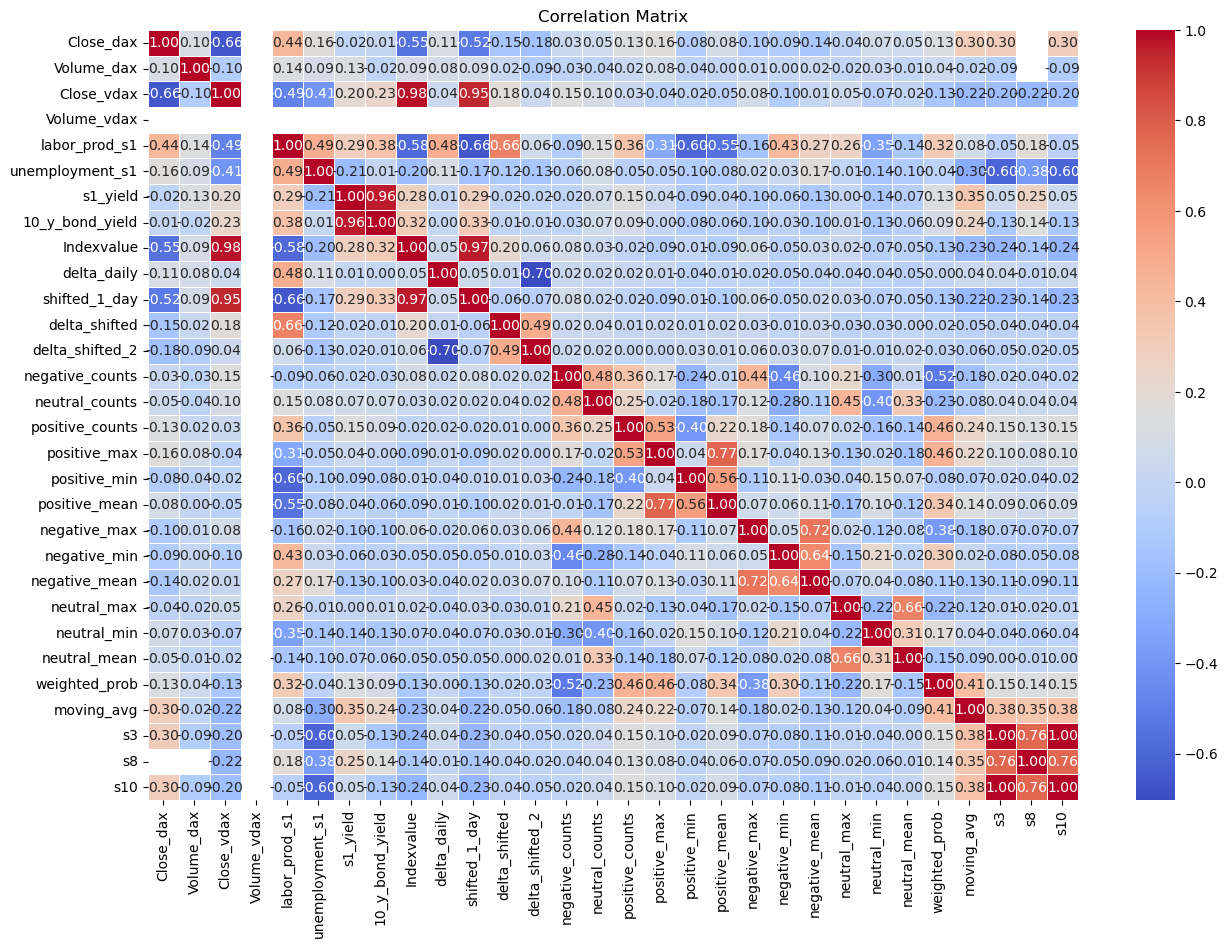

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [146]:
# Compute correlations of each column against 'weighted_prob'
correlations = {}
for col in merged_df.columns:
    if merged_df[col].dtype in ['float64', 'int64'] and col != 'weighted_prob':
        correlations[col] = merged_df[col].corr(merged_df['weighted_prob'])

# Convert dictionary to a DataFrame for better visualization and sorting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation_with_weighted_prob'])

# Sort by the absolute value of correlation to get a ranking
correlation_df['Abs_Correlation'] = correlation_df['Correlation_with_weighted_prob'].abs()
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display the ranked correlations
print(correlation_df)


           Variable  Correlation_with_weighted_prob
13  negative_counts                       -0.518381
15  positive_counts                        0.462270
16     positive_max                        0.461506
25       moving_avg                        0.409274
19     negative_max                       -0.380445
18    positive_mean                        0.344238
4     labor_prod_s1                        0.319485
20     negative_min                        0.297973
14   neutral_counts                       -0.226888
22      neutral_max                       -0.224788
23      neutral_min                        0.167157
24     neutral_mean                       -0.145156
2        Close_vdax                       -0.132284
6          s1_yield                        0.130959
8        Indexvalue                       -0.129328
10    shifted_1_day                       -0.126250
0         Close_dax                        0.125476
21    negative_mean                       -0.109218
7   10_y_bon

# LSTM model with proper data preprocessing

In [203]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data
features = merged_df[['Date','10_y_bond_yield', 'weighted_prob', 's1_yield', 'Indexvalue', 'day_of_week', 's10', 'moving_avg']]

# drop if day_of_week is NaN
features = features[features['day_of_week'].notna()]


In [204]:
features

,Date,10_y_bond_yield,weighted_prob,s1_yield,Indexvalue,day_of_week,s10,moving_avg
17,2005-12-12,3.422117,0.563371,2.994022,13.2823,Monday,0.25,0.192087
23,2005-12-20,3.354752,0.033634,3.009004,12.4045,Tuesday,0.25,0.199128
24,2005-12-21,3.377665,0.213713,3.062166,12.4621,Wednesday,0.25,0.213734
47,2006-01-26,3.440676,0.519109,3.137711,14.7677,Thursday,0.25,0.217210
48,2006-01-27,3.462251,-0.582294,3.172167,15.1492,Friday,0.25,0.115711
...,...,...,...,...,...,...,...,...
4810,2018-05-28,0.431265,-0.073901,-0.521174,17.7786,Monday,-0.05,-0.057561
4812,2018-09-03,0.366308,0.395389,-0.469308,15.4945,Monday,-0.05,-0.035507
4816,2019-02-18,0.156501,-0.291025,-0.526818,14.5378,Monday,-0.05,0.081589
4822,2020-02-17,-0.364267,-0.140924,-0.698982,12.9654,Monday,0.00,-0.103287


In [206]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features.columns:
    dummies = pd.get_dummies(features['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features = features.drop('day_of_week', axis=1)
    features = pd.concat([features, dummies], axis=1)


In [210]:
# 2. Scale the data but exclude the 'Date' column
dates = features['Date']  # Store the dates temporarily
features_without_date = features.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date = scaler.fit_transform(features_without_date)


In [211]:

# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled_df = pd.DataFrame(scaled_data_without_date, columns=features_without_date.columns)
scaled_df['Date'] = dates.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data = scaled_df.drop(columns=['Date']).values

sequence_length = 60  # Assuming a sequence length of 60

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [215]:
X.shape, y.shape

((1031, 60, 9), (1031,))

In [221]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Assuming 'features' and 'targets' are already created and split as X and y, respectively.

# Split data (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features))) # Use num_features instead of 4
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store its history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Access training and validation loss (can be plotted or analyzed further)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Evaluate model
predicted_bond_price = model.predict(X_test)

# Assuming the original number of features (excluding 'Date') is 10
num_original_features = 10

# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price.ravel()

# Now inverse transform this array
inverse_transformed = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price = inverse_transformed[:, 0]


Epoch 1/50
26/26 [==============================] - 4s 55ms/step - loss: 0.0469 - val_loss: 0.0237
Epoch 2/50
26/26 [==============================] - 1s 34ms/step - loss: 0.0043 - val_loss: 0.0266
Epoch 3/50
26/26 [==============================] - 1s 35ms/step - loss: 0.0027 - val_loss: 0.0247
Epoch 4/50
26/26 [==============================] - 1s 34ms/step - loss: 0.0020 - val_loss: 0.0268
Epoch 5/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 0.0272
Epoch 6/50
26/26 [==============================] - 1s 35ms/step - loss: 0.0017 - val_loss: 0.0291
Epoch 7/50
26/26 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 0.0254
Epoch 8/50
26/26 [==============================] - 1s 44ms/step - loss: 0.0015 - val_loss: 0.0273
Epoch 9/50
26/26 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 0.0258
Epoch 10/50
26/26 [==============================] - 1s 43ms/step - loss: 0.0013 - val_loss: 0.0276
Epoch 11/

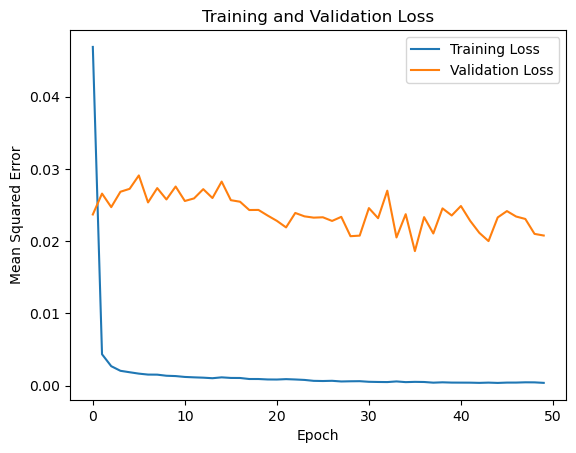

In [222]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [223]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {test_mse}")


Mean Squared Error on test set: 0.02077386900782585


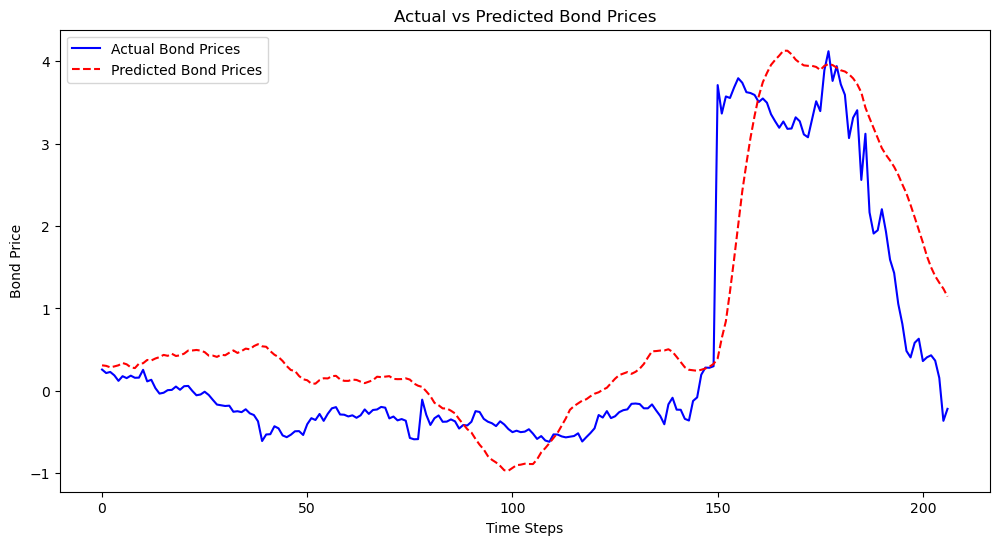

In [225]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test.reshape(-1, 1)

# Create a placeholder array. It will be the same shape as the data used to 
# train the MinMaxScaler, but with zeros in places we don't want to inverse transform.
placeholder_array = np.zeros((y_test_2d.shape[0], 10))  # 10 for the number of original features

# Assign the bond prices from y_test to the first column of this placeholder array.
# This assumes that 'bond_price' was the first column in the original data used to fit the scaler.
placeholder_array[:, 0] = y_test_2d.ravel()


# Step 2: Performing the inverse transformation
# ----------------------------------------------
# This will get the actual bond prices back in their original scale
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

# Assuming 'final_predicted_bond_price' contains the inverse transformed predictions from the model
predicted_prices = final_predicted_bond_price

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plot the actual bond prices
plt.plot(actual_prices, label="Actual Bond Prices", color='blue')

# Plot the predicted bond prices
plt.plot(predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Add labels, title, and legend
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")

# Display the plot
plt.show()


KeyError: 60

Epoch 1/50
12/12 [==============================] - 1s 86ms/step - loss: 0.0028 - val_loss: 0.3370
Epoch 2/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0028 - val_loss: 0.3138
Epoch 3/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0028 - val_loss: 0.3416
Epoch 4/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0030 - val_loss: 0.2734
Epoch 5/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0026 - val_loss: 0.2818
Epoch 6/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0027 - val_loss: 0.2932
Epoch 7/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0026 - val_loss: 0.2603
Epoch 8/50
12/12 [==============================] - 0s 36ms/step - loss: 0.0023 - val_loss: 0.2602
Epoch 9/50
12/12 [==============================] - 0s 36ms/step - loss: 0.0023 - val_loss: 0.2507
Epoch 10/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0024 - val_loss: 0.2281
Epoch 11/

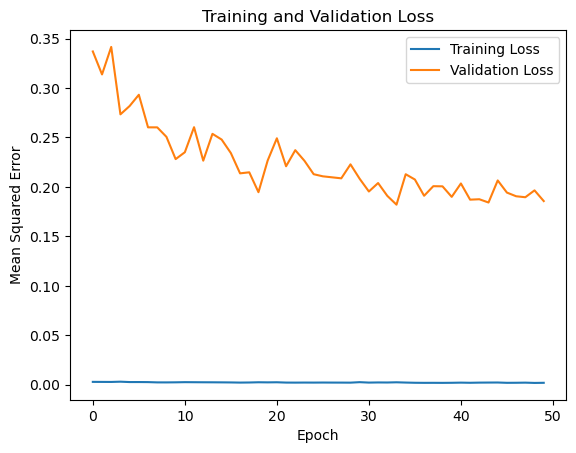

In [103]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [104]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {test_mse}")


Mean Squared Error on test set: 0.18570001423358917


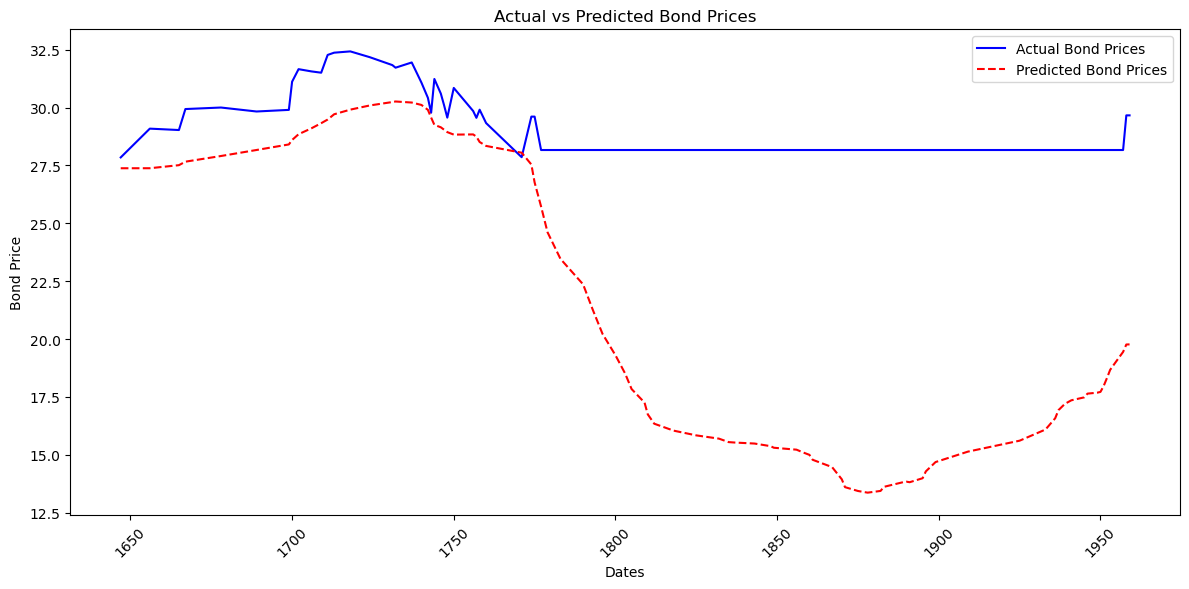

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test.reshape(-1, 1)

# Create a placeholder array. It will be the same shape as the data used to 
# train the MinMaxScaler, but with zeros in places we don't want to inverse transform.
placeholder_array = np.zeros((y_test_2d.shape[0], 5))  # 5 for the number of original features

# Assign the bond prices from y_test to the first column of this placeholder array.
# This assumes that 'bond_price' was the first column in the original data used to fit the scaler.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
# This will get the actual bond prices back in their original scale
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

#
predicted_prices = final_predicted_bond_price
# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Plot the actual bond prices with dates
plt.plot(test_dates, actual_prices, label="Actual Bond Prices", color='blue')

# Plot the predicted bond prices with dates
plt.plot(test_dates, predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Add labels, title, and legend
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Dates")
plt.ylabel("Bond Price")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Display the plot
plt.tight_layout()  # Adjust layout for better visibility
plt.show()


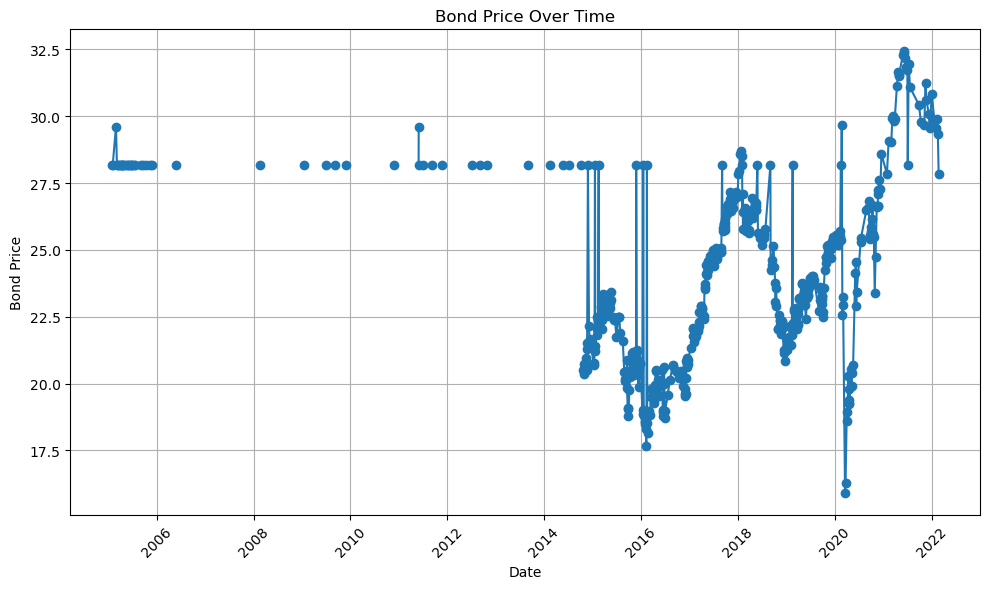

In [106]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort the DataFrame by the 'Date' column (optional but recommended)
merged_df = merged_df.sort_values(by='Date')

# Create a line plot
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
plt.plot(merged_df['Date'], merged_df['bond_price'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Bond Price')
plt.title('Bond Price Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()